# Code
## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from construct_data import construct_data
%matplotlib inline

## Visualize training data and posterior

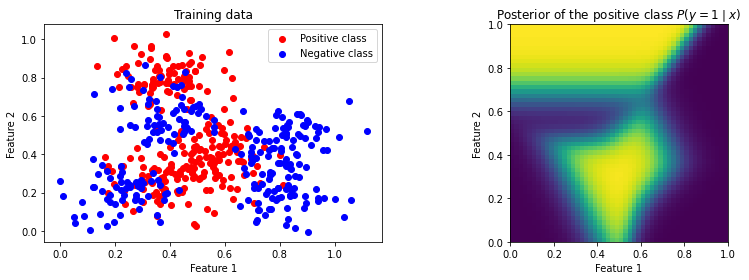

In [2]:
features, labels, posterior = construct_data(500, 'train', 'nonlinear', plusminus=True)

# Extract features for both classes
features_pos = features[labels == 1]
features_neg = features[labels != 1]

# Display data
fig = plt.figure(figsize=plt.figaspect(0.3))
ax = fig.add_subplot(1, 2, 1)
ax.scatter(features_pos[:, 0], features_pos[:, 1], c="red", label="Positive class")
ax.scatter(features_neg[:, 0], features_neg[:, 1], c="blue", label="Negative class")
           
ax.set_title("Training data")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.legend()
           
ax = fig.add_subplot(1, 2, 2)
ax.imshow(posterior, extent=[0, 1, 0, 1], origin='lower')
ax.set_title("Posterior of the positive class $P(y=1 \mid x)$")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
           
plt.show()

## Train the classifier
### Weak learner evaluation

In [3]:
def evaluate_stump(features, polarity_wl, theta_wl, coordinate_wl):
    """Evaluate the stump's response for each point."""
    feature_slice = features[:, coordinate_wl]
    weak_learner_output = polarity_wl * (2 * (feature_slice >= theta_wl) - 1)
    return weak_learner_output

def evaluate_stump_on_grid(x_rng, y_rng, polarity_wl, theta_wl, coordinate_wl):
    """Evaluate the stump's response for each point on a rectangular grid."""
    feature_slice = np.meshgrid(x_rng, y_rng)[coordinate_wl]
    weak_learner_on_grid = polarity_wl * (2 * (feature_slice >= theta_wl) - 1)
    return weak_learner_on_grid

### Finding the best weak learner

In [4]:
Theta_Choice = features.shape[0]
print(Theta_Choice)
Dimension_Choice = features.shape[1]
print(Dimension_Choice)

500
2


In [5]:
def find_best_weak_learner(weights, features, labels):
    """Find the best decision stump for the given weight distribution.
     Returns
     -------
     polarity_wl : {-1, 1}
     Polarity 's' of the decision stump.
     theta_wl : float
     Threshold 'theta' for the decision.
     coordinate_wl : int
     Dimension 'd' along which the threshold is applied.
     err_wl : float
     Weighted error for the decision stump.
     """
    # TODO (Question 1)
    # /TODO (Question 1)
    
    # Define the return value (type) same with above
    polarity_wl = 1
    theta_wl = 0.0
    coordinate_wl = 0
    
    # Define the err_wl to be positive infinite
    err_wl = float('inf')
    
    # features => (500, 2) features.shape[1] = 2 (dimension)
    Dimension_Choice = features.shape[1] 
    S_Value_Array = np.array([-1, 1])
    
    for s_value in S_Value_Array:
        for dimension in range(Dimension_Choice):
            for theta in features[:, dimension]:

                # Calculate total error of this combination
                total_error = 0.0
                Weak_Learner_Result = evaluate_stump(features, s_value, theta, dimension)
                
                # If the point not classify correctly, it will multiply the weights and calculate the total error 
                # Method conception from Assignment 3
                total_error = np.sum((Weak_Learner_Result != labels) * weights)
                
                # Find the minimum total_error
                if np.abs(err_wl) > np.abs(total_error):
                    polarity_wl = s_value
                    theta_wl = theta
                    coordinate_wl = dimension
                    err_wl = total_error
    
    return polarity_wl, theta_wl, coordinate_wl, err_wl

### AdaBoost algorithm

In [6]:
npoints, nfeatures = features.shape
num_rounds_boosting = 400

# Initialize arrays.
weights = np.ones(npoints) / npoints # Weight distribution on samples
f = np.zeros((num_rounds_boosting, npoints)) # Strong classifier response at each iteration
loss = np.zeros(num_rounds_boosting) # AdaBoost loss function
num_errors = np.zeros(num_rounds_boosting) # Number of errors at each round
f_on_grid = 0 # Used to plot function

x_rng = y_rng = np.linspace(0, 1, 50)
for i in range(num_rounds_boosting):
    ## TODO (Question 1)
    
    # Find best weak learner at current round of boosting.
    polarity_wl, theta_wl, coordinate_wl, err_wl = find_best_weak_learner(weights, features, labels)
    
    # Estimate alpha.
    # We can find the formula on the 4_ensembles pdf slide 20
    Log_Value = np.log(1 - err_wl) - np.log(err_wl)
    alpha = 0.5 * Log_Value

    # Reweight samples.
    # Calculate the ht(xi)
    Weak_Learner_Result = evaluate_stump(features, polarity_wl, theta_wl, coordinate_wl)

    # Calculate the -αt * yi * ht(xi)
    Multiply_Result = (-alpha) * labels * Weak_Learner_Result
    # According to the formula on the slide to calculate Zt and update weights
    weights = weights * np.exp(Multiply_Result)
    # Calculate the Zt
    Zt = np.sum(weights)
    # Reweights = (weights) / Zt
    weights = (weights) / Zt
    
    ## /TODO (Question 1)

    ## TODO (Question 2)
    # Compute overall response at current round.
    # Set the f[i] value when i == 0
    if i == 0:
        f[i] = alpha * Weak_Learner_Result
    # f'(x) = f(x) + αh(x)
    else:
        f[i] = f[i - 1] + alpha * Weak_Learner_Result
        
    # Compute loss at current round.             
    # Calculate -yi * f'(xi)
    Exponential_Value = -labels * f[i]
    # Calculate the total loss at each round
    for exp_result in Exponential_Value:
        loss[i] = loss[i] + np.exp(exp_result)        
    
    # Keep track of the number of errors given by the final classifier.
    
    # Calculate sigma(t = 1 -> T) αt * ht(x)
    # Define the Sum and Hx to record the value and sign number
    Sum = np.zeros(features.shape[0])
    Hx = np.zeros(features.shape[0])
    Sum = Sum + f[i]
    
    for t in range(len(Weak_Learner_Result)):
        # Obtain Final Classifier
        Hx[t] = np.sign(Sum[t])
    # Calculate the total error
    num_errors[i] = np.sum(Hx != labels)
                 
    ## /TODO (Question 2)

    # Evaluate f on a grid to produce the images.
    weak_learner_on_grid = evaluate_stump_on_grid(x_rng, y_rng, polarity_wl, theta_wl, coordinate_wl)
    
    # f_on_grid += alpha*weak_learner_on_grid
    f_on_grid += alpha*weak_learner_on_grid
    
    
    # Save gridded f at specific iterations.
    if i == 10:
        f_10 = f_on_grid.copy()
    elif i == 50:
        f_50 = f_on_grid.copy()
    elif i == 100:
        f_100 = f_on_grid.copy()

## Visualize loss function

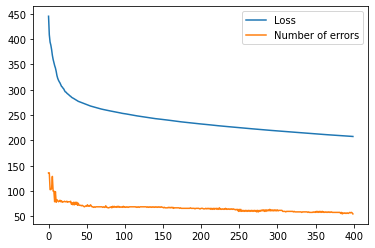

In [7]:
## TODO (Question 2)
## /TODO (Question 2)

fig, ax = plt.subplots()
# Print the plot (loss at each round)
ax.plot(loss, label = "Loss")
# Print the plot (number of errors given by the final classifier)
ax.plot(num_errors, label = "Number of errors")
# Show the label
ax.legend()
plt.show()

## Visualize strong learner progress

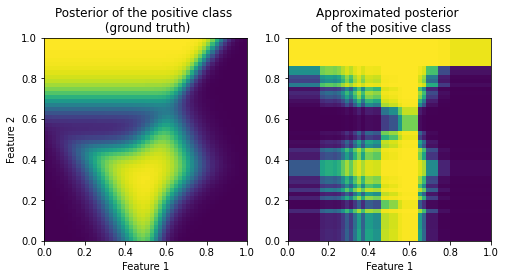

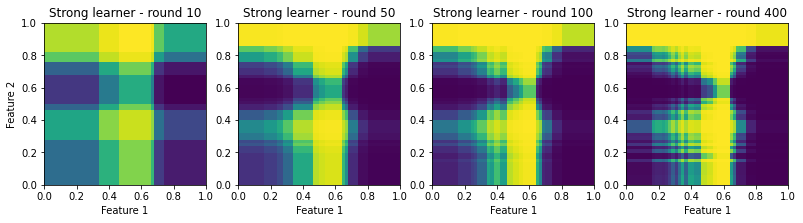

In [9]:
approx_posterior_10 = 1 / (1 + np.exp(-2 * f_10))
approx_posterior_50 = 1 / (1 + np.exp(-2 * f_50))
approx_posterior_100 = 1 / (1 + np.exp(-2 * f_100))
approx_posterior_400 = 1 / (1 + np.exp(-2 * f_on_grid))

# TODO (Question 3)
# /TODO (Question 3)

features, labels, posterior = construct_data(500, 'train', 'nonlinear', plusminus=True)

# Extract features for both classes
features_pos = features[labels == 1]
features_neg = features[labels != 1]

# Display data
fig = plt.figure(figsize = plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(posterior, extent = [0, 1, 0, 1], origin = 'lower')
ax.set_title("Posterior of the positive class \n (ground truth)")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")

posterior = 1 / (1 + np.exp(-2 * f_on_grid))

ax = fig.add_subplot(1, 2, 2)
ax.imshow(posterior, extent = [0, 1, 0, 1], origin = 'lower')
ax.set_title("Approximated posterior \n of the positive class")
ax.set_xlabel("Feature 1")

# Plot Strong Learner plot
fig = plt.figure(figsize = plt.figaspect(0.3))
ax = fig.add_subplot(1, 4, 1)
ax.imshow(approx_posterior_10, extent = [0, 1, 0, 1], origin = 'lower')
ax.set_title("Strong learner - round 10")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")

ax = fig.add_subplot(1, 4, 2)
ax.imshow(approx_posterior_50, extent = [0, 1, 0, 1], origin = 'lower')
ax.set_title("Strong learner - round 50")
ax.set_xlabel("Feature 1")

ax = fig.add_subplot(1, 4, 3)
ax.imshow(approx_posterior_100, extent = [0, 1, 0, 1], origin = 'lower')
ax.set_title("Strong learner - round 100")
ax.set_xlabel("Feature 1")

ax = fig.add_subplot(1, 4, 4)
ax.imshow(approx_posterior_400, extent = [0, 1, 0, 1], origin = 'lower')
ax.set_title("Strong learner - round 400")
ax.set_xlabel("Feature 1")

plt.show()